##Trying out Tychonoff regularization

I'm not sure this will help very much, since starting from an approximately-correct rectilinear grid seems to me to be an equivalent assertion of a prior, but since Aaron and Gary Bernstein are optimistic, let's give it a try.

In [1]:
%matplotlib inline
import weak_sauce as ws
import weak_sauce.data_tools
import numpy as np
import matplotlib.pyplot as plt
from __future__ import division

from weak_sauce.movers import UniformIlluminationMover
from weak_sauce.fit_flat import FlatFitter

from weak_sauce.movers import UniformGaussianMover
from weak_sauce.grid import MoveableGrid
from weak_sauce.sources import Source

full_amp_img = np.load('../data/lsst_ultraflat_75ke_amp3.npy')
full_detrend_img = weak_sauce.data_tools.detrend(full_amp_img)

In [2]:
test_img = full_amp_img[1000:1050,200:250]
test_detrend = full_detrend_img[1000:1050,200:250]

In [3]:
local_mean = np.mean(test_img)
data_rel_flux_map = test_detrend/local_mean+1

In [4]:
data_like_mover = UniformIlluminationMover()
data_like_source = Source(num_x=51) 
data_like_source.fluxes += 1 #fit to flat field
data_mg = MoveableGrid(data_like_source,data_like_mover)
fitter = FlatFitter(data_rel_flux_map, luminosity=1)

Ok, a few steps seems ok; let's do the full thing!

In [29]:
def doTest(max_steps,tycho_param):
    data_like_mover = UniformIlluminationMover()
    data_like_source = Source(num_x=51) 
    data_like_source.fluxes += 1 #fit to flat field
    data_mg = MoveableGrid(data_like_source,data_like_mover)
    fitter = FlatFitter(data_rel_flux_map, luminosity=1,tychoX=tycho_param,tychoY=tycho_param)
    oldlnlike = -10000
    lnlike = -10000
    for stepnum in xrange(max_steps):
        fitter(data_mg.source, step_size=1e-3)
        lnlike, oldlnlike = fitter.lnlike(data_mg.source.vertices, data_mg.source.fluxes), lnlike
        if lnlike < oldlnlike:
            break
    data_mg.source.plot(data_rel_flux_map, pcolormesh_kwargs_in={'linewidths':0})
    plt.title('Data')
    data_mg.source.plot(data_rel_flux_map - data_mg.source.fluxes, pcolormesh_kwargs_in={'linewidths':0})
    plt.title('Data-Model')
    plt.figure()
    plt.title('Image Histograms')
    _ = plt.hist([data_rel_flux_map.flatten(), data_mg.source.fluxes.flatten()],
                 bins=50, histtype='step',label=['Data','Model'])
    plt.legend()
    plt.figure()
    plt.title('Residuals')
    _ = plt.hist((data_mg.source.fluxes - data_rel_flux_map).flatten(),bins=50)
    print 'final stepnum was ', stepnum
    print 'sigma_data: ', np.std(data_rel_flux_map), 'sigma_resid: ', \
    np.std(data_mg.source.fluxes - data_rel_flux_map), 'frac: ',\
    np.std(data_mg.source.fluxes - data_rel_flux_map)/np.std(data_rel_flux_map)
    #plt.close('all')
    return stepnum, np.std(data_mg.source.fluxes - data_rel_flux_map)/np.std(data_rel_flux_map)

So at this point, the Tychonoff regularization is cutting us off too early. The residual pattern is featureless, but the likelihood break condition is triggered after only 45 steps...
Time to mess around with the regularization parameter!

In [27]:
#leave plt.close uncommented
tycho_vec = np.arange(.1,5,.2)
stepnum_vec = []
resid_frac_vec = []

for tycho_param in tycho_vec:
    a,b = doTest(10000,tycho_param)
    stepnum_vec.append(a)
    resid_frac_vec.append(b)

final stepnum was  8
sigma_data:  0.00339981436549 sigma_resid:  0.00332778919222 frac:  0.97881496884
final stepnum was  62
sigma_data:  0.00339981436549 sigma_resid:  0.00294159849029 frac:  0.865223266349
final stepnum was  155
sigma_data:  0.00339981436549 sigma_resid:  0.00241893591742 frac:  0.711490586656
final stepnum was  268
sigma_data:  0.00339981436549 sigma_resid:  0.00196057094881 frac:  0.576669999608
final stepnum was  392
sigma_data:  0.00339981436549 sigma_resid:  0.00160502189726 frac:  0.472091039308
final stepnum was  523
sigma_data:  0.00339981436549 sigma_resid:  0.00133869674349 frac:  0.393755834754
final stepnum was  660
sigma_data:  0.00339981436549 sigma_resid:  0.00113873723141 frac:  0.33494100236
final stepnum was  805
sigma_data:  0.00339981436549 sigma_resid:  0.000984625242007 frac:  0.289611471733
final stepnum was  959
sigma_data:  0.00339981436549 sigma_resid:  0.000864061653946 frac:  0.254149656733
final stepnum was  1125
sigma_data:  0.0033998143

So with Tychonoff, we are running into our requirement that the likelihood always increase much sooner than we would like. It appears that tychonoff does kill the checkerboard pattern, but also makes the residual power much higher than the unregularized method. So at this point we have a choice between a featureless large residual and a small but checkerboard patterned one. Let's try running without the likelihood increase requirement. In a sense, we want the model to be able to free itself from local minima anyway...

final stepnum was  4999
sigma_data:  0.00339981436549 sigma_resid:  0.00863877361519 frac:  2.54095450119


(4999, 2.5409545011889345)

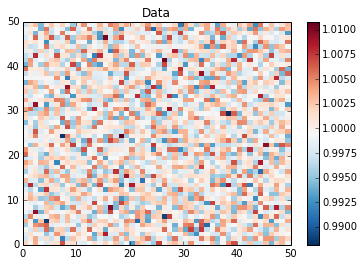

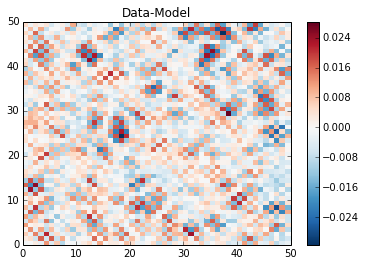

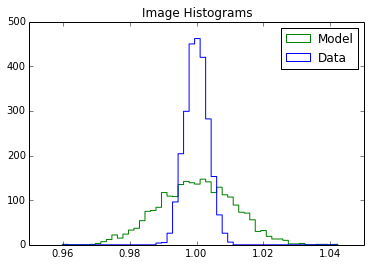

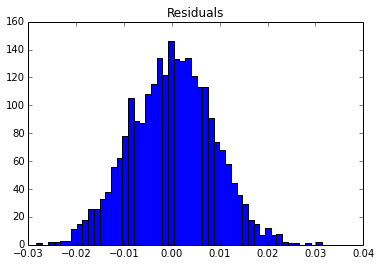

In [39]:
#comment out likelihood requirement
doTest(5000,1)

Still not looking great, but TBC...